In [1]:
# Database
import sqlite3

# Machine learning
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split

# NLP
import spacy

# Plots
import matplotlib.pyplot as plt

# Own fns
import preprocessing
import model_utils as model_utils


# 0. Fetch data from db

In [2]:
database_file_name = "db_analytic_multi-class.sqlite"

con = sqlite3.connect(f"../../db/{database_file_name}")

cur = con.cursor()

In [3]:
sql_file_name = "select_all_text_multi-class.sql"

# TODO: Use sqlutils.get_sql_statement()
with open(f"../../db/sql/{sql_file_name}") as sql_file:
    sql = sql_file.read()
    sql_file.close()

cur.execute(sql)

'''
Response format: list[(text, categories)]
'''
response = cur.fetchall()

In [13]:
# TODO: Vérifier l'equilibrage des classes
data_dict = {}
'''
Format: {[categories[]]: list[page_text_content]}
'''

for page in response:
    text = page[0]
    raw_category: str = page[1]

    if raw_category is None:
        continue

    categories = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

    for elt in raw_category.split(","):
        categories[int(elt)] = 1

    categories = str(categories)[1:-1].replace(" ","")
    # print(str(categories)[1:-1].replace(" ",""))
    if categories not in list(data_dict.keys()):
        data_dict[categories] = [text]
    else :
        data_dict[categories].append(text)

print(len(data_dict[list(data_dict.keys())[0]]))

125


# 1. Cleaning

In [14]:
cleaned_data_dict = {}
nlp = spacy.load("fr_core_news_lg")

for category in list(data_dict.keys()):
    cleaned_data_dict[category] = []

for category in list(data_dict.keys()):
    for text_content in data_dict[category]:
        cleaned_text = preprocessing.full_cleaning(text_content, nlp)

        cleaned_data_dict[category].append(cleaned_text)

print(cleaned_data_dict)

{'0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0': ['entretenir exterieur travail exterieur ryobi debroussailleus an debroussailleus ryobi electriqu wv ideal travail finition petit herbe haut retrouver outil coupe coupe net precise tete semi automatique double fil cm avancer automatique fil simple ryobi pression sol lame taillis dent cm double affutage dent reversibl ref eco part recyclage combine an combine taille haie perche electriqu ryobi rp appareil filaire usage perche branche tailler haie hauteur demontabl facile ranger perche puissant moteur ideal petit elagage pack an incliner precision confort longueur maximal cm tube extension fibr verre cm leger maniable harnais bretell pack tondeus up ergonomique niveau huile visible controle facile rapide ref kit comprendre tondeus cm batterie ov sah eco part recyclage chargeur standard jusqua autonomie charg batteri tonte reguliere tondeus cm fil batterie up allier puissance autonomie faciliter utilisation liberte mouvement emet aucun emission polluant

# 2. Create a vocabulary

In [15]:
# String containing all the words
all_text = ""

for category in list(cleaned_data_dict.keys()):
    temp_text = " ".join(cleaned_data_dict[category])
    print(temp_text)

    if category == list(cleaned_data_dict.keys())[0]:
        all_text += temp_text
    else:
        all_text += " " + temp_text

# TODO: Fix "'" should not be in the vocabulary ! Check preprocessing.clean_text
vocabulary = np.unique(all_text.split(" "))
print(list(vocabulary))
print(len(list(vocabulary)))

entretenir exterieur travail exterieur ryobi debroussailleus an debroussailleus ryobi electriqu wv ideal travail finition petit herbe haut retrouver outil coupe coupe net precise tete semi automatique double fil cm avancer automatique fil simple ryobi pression sol lame taillis dent cm double affutage dent reversibl ref eco part recyclage combine an combine taille haie perche electriqu ryobi rp appareil filaire usage perche branche tailler haie hauteur demontabl facile ranger perche puissant moteur ideal petit elagage pack an incliner precision confort longueur maximal cm tube extension fibr verre cm leger maniable harnais bretell pack tondeus up ergonomique niveau huile visible controle facile rapide ref kit comprendre tondeus cm batterie ov sah eco part recyclage chargeur standard jusqua autonomie charg batteri tonte reguliere tondeus cm fil batterie up allier puissance autonomie faciliter utilisation liberte mouvement emet aucun emission polluant utilisation ref eco part recyclage ry

In [16]:
# Save the vocabulary
vocabulary_file_name = "vocab_multi-class.txt"

with open(f"./{vocabulary_file_name}", "w") as vocabulary_file:
    for token in list(vocabulary):
        if token == list(vocabulary)[-1]:
            vocabulary_file.write(token)
        else:
            vocabulary_file.write(token+"|")
    
    vocabulary_file.close()

# 3. Feature extraction (BOW)

In [17]:
X = []
y = []

for category in list(cleaned_data_dict.keys()):
    for text in cleaned_data_dict[category]:
        X.append(preprocessing.get_bags_of_words_vector(text, vocabulary))
        # y.append(int(category)) # category should be integer from db
        y.append(category.split(","))

print(len(X))
print(len(y))

1203
1203


# 4. Model

In [18]:
# class PageClassifier(nn.Module):
#     def __init__(self, input_features, output_features):
#         super().__init__()
#         self.linear_layer_stack = nn.Sequential(
#             nn.Linear(in_features=input_features, out_features=128, dtype=torch.float32),
#             nn.ReLU(),
#             nn.Linear(in_features=128, out_features=output_features, dtype=torch.float32),
#         )

#     def forward(self, x):
#         return self.linear_layer_stack(x)

class PageClassifierMultiLabel(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, 128),
            nn.ReLU(),
            nn.Linear(128, output_features),
            nn.Sigmoid(),  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# 5. Training

In [140]:
# TODO: Put in utils file
# def accuracy_fn(y_true, y_pred):
#     print("y_pred", y_pred)
#     print("y_true", y_true)

#     correct = (
#         torch.eq(input=y_true, other=y_pred).sum().item()
#     )  # torch.eq() calculates where two tensors are equal
#     acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
#     return acc

def accuracy_fn(y_true, y_pred):
    print("y_pred", y_pred)
    print("y_true", y_true)

    new_y_pred = []
    
    for elt in y_pred:
        new_elt = []
        for subelt in elt:
            if subelt >= 0.5:
                new_elt.append(1)
            else:
                new_elt.append(0)
        new_y_pred.append(new_elt)

    print(y_true.dtype)
    new_y_pred = torch.tensor(new_y_pred).type(torch.float32)
    print("new_y_pred", new_y_pred)

    # correct = (
    #     torch.eq(input=y_true, other=new_y_pred).sum().item()
    # )  # torch.eq() calculates where two tensors are equal
    correct = 0
    for i in range(len(new_y_pred)):
        if list(new_y_pred[i]) == list(y_true[i]):
            correct +=1
    acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
    return acc


# def accuracy_fn(y_true, y_pred_probs, threshold=0.5):
#     """
#     Compute accuracy for multi-label classification.
    
#     Args:
#         y_true (torch.Tensor): Ground truth labels (binary tensors).
#         y_pred_probs (torch.Tensor): Predicted probabilities.
#         threshold (float): Threshold for considering a prediction as positive.
    
#     Returns:
#         float: Accuracy.
#     """
#     # Convert probabilities to binary predictions using threshold
#     y_pred_binary = (y_pred_probs >= threshold).float()
    
#     # Compute accuracy
#     correct_predictions = (y_pred_binary == y_true).all(dim=1).sum().item()
#     total_predictions = y_true.size(0)
#     accuracy = correct_predictions / total_predictions * 100.0
    
#     return accuracy


In [114]:
# TODO: Put in utils file
def display_training_metrics(
    epochs: int,
    loss_history: list[float],
    test_loss_history: list[float],
    acc_history: list[float],
    test_acc_history: list[float],
):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Training loss")
    plt.plot(range(epochs), test_loss_history, label="Testing loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), acc_history, label="Training acc")
    plt.plot(range(epochs), test_acc_history, label="Testing acc")
    plt.legend()
    plt.title("Accuracy")

    plt.show()

In [143]:
def training_loop(PageClassifier, X, y):
    loss_history, acc_history, val_loss_history, val_acc_history = [], [], [], []

    # Init model
    torch.manual_seed(42)
    # ! +1 is a dirty fix of missing category due to bug during labeling (sport and multimedia categories merged)
    # model = PageClassifier(input_features=len(X[0]), output_features=len(list(set(y)))+1) # ! +1 is to remove !!!! 
    
    unique_y = []
    for elt in y:
        unique_y.append(str(elt)[1:-1].replace(" ","").replace("'", ""))

    print("output features", len(list(set(unique_y))))
    
    model = PageClassifier(input_features=len(X[0]), output_features=16) # ! +1 is to remove !!!!

    loss_fn = nn.BCELoss() # ! Use BCELoss for multi-label classification !
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Prepare data
    X = torch.tensor(X).type(torch.float32)
    # y = torch.tensor(y).type(torch.long)
    # y = torch.tensor(y).type(torch.float32)
    y_copy = y
    y = []
    for elt in y_copy:
        # print("elt", elt)
        new_elt = []
        for subelt in elt:
            # print("subelt", subelt)
            new_elt.append(int(subelt))
        y.append(new_elt)

    print("y", y)
    y = torch.tensor(y).type(torch.float32)
    # TODO: Print dtype
    # print("y dtype", y.dtype)


    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 20

    for epoch in range(epochs):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        # print("y_logits[0]", y_logits[0])
        # print(("y_logits dtype", y_logits.dtype))
        # y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        # print("y_pred", y_pred)

        y_pred_probs = torch.sigmoid(y_logits)
        # print("y_ped_probs", y_pred_probs)

        # 2. Metrics
        loss = loss_fn(y_pred_probs, y_train)
        # TODO: Setup accuracy
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred_probs)

        # 2.1 Save metrics
        loss_history.append(loss.cpu().detach().numpy())
        acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Validation
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_val_logits = model(X_val)
            # y_val_pred = torch.softmax(y_val_logits, dim=1).argmax(dim=1)
            y_val_pred_probs = torch.sigmoid(y_val_logits)


            # 2. Metrics
            val_loss = loss_fn(y_val_pred_probs, y_val)
            val_acc = accuracy_fn(y_true=y_val, y_pred=y_val_pred_probs)

            # 2.1 Save metrics
            val_loss_history.append(val_loss.cpu().detach().numpy())
            val_acc_history.append(val_acc)

        # Print out what's happening
        # if epoch % 25 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {val_loss:.5f}, Test Acc: {val_acc:.2f}%"
        )
        # print(
        #     f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {val_loss:.5f}"
        # )
    display_training_metrics(
        epochs, loss_history, val_loss_history, acc_history, val_acc_history
    )
    return model

output features 30
y [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 

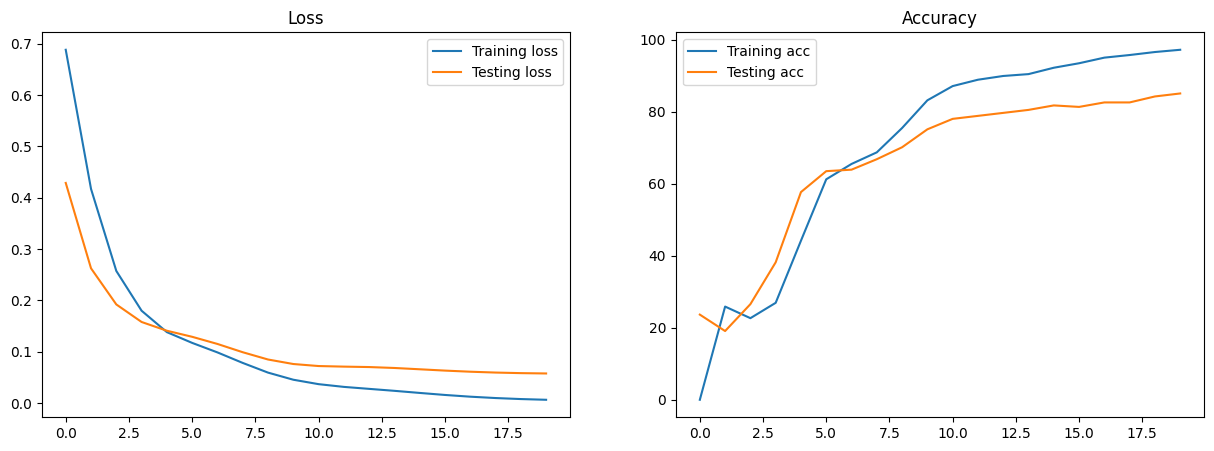

In [144]:
model = training_loop(model_utils.PageClassifier, X, y)

# 6. Save the model

In [15]:
torch.save(model.state_dict(), "./model_weight_multi-class.pth")

# 7. Prediction

In [16]:
# def predict(model, input: list[int], label_mapping: dict[str]):
#     model.eval()

#     with torch.inference_mode():
#         X = torch.tensor([input]).type(torch.float32)
#         y_logits = model(X)
#         y_softmax = torch.softmax(y_logits, dim=1)
#         y_pred = y_softmax.argmax(dim=1)
        
#         result = y_softmax.detach().numpy()
#         class_prediction = label_mapping[y_pred.detach().numpy()[0]]

#         print("result", result)
#         print("class_prediction =>", class_prediction)

In [18]:
# TODO: Use real test data
input = preprocessing.pipeline_from_raw_text_to_vectors(
    data_dict[1][-1], nlp, vocabulary
)
print(input)
model_utils.predict(model, input)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1

TODO:
- Try auto-sklearn
- Try lazy predict
- Create model.py (with pytorch)